In [1]:
import dill as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Process Scraped Data

In [2]:
with open("../data/cpu_specs_raw_tables.pkl", "rb") as f:
    payload = pickle.load(f)

In [3]:
for k in payload:
    print(k)

tables
errors
resolved
unresolved


In [4]:
models = [k for k in payload["tables"]]
print(models)

['AMD Ryzen 9 9950X', 'AMD RYZEN AI MAX+ 395', 'Intel Core i9-13900K', 'AMD Ryzen 7 7700X', 'AMD Ryzen 9 7950X', 'Intel Core i9-14900K', 'AMD EPYC 4364P', 'AMD Ryzen 9 7900X', 'Intel Core i9-12900K', 'AMD EPYC 4564P', 'AMD EPYC 4464P', 'AMD EPYC 4584PX', 'AMD EPYC 4484PX', 'AMD Ryzen 9 5900X', 'AMD Ryzen 5 7600X', 'Intel Core i9-11900K', 'AMD Ryzen 9 5950X', 'AMD Ryzen 7 5800X', 'AMD Ryzen 7 5800X3D', 'Intel Core i9-10900K', 'Intel Core i5-13600K', 'AMD EPYC 4124P', 'AMD Ryzen Threadripper 3970X', 'AMD Ryzen Threadripper 3990X', 'AMD Ryzen 9 3900XT', 'Intel Core i5-12600K', 'Intel Core i7-7900X', 'Intel Core i5-11600K', 'Intel Core i9-7980XE', 'Intel Core i5-13400', 'AMD Ryzen 7 PRO 5850U', 'AMD Ryzen Threadripper 2990WX', 'AMD Ryzen 7 PRO 6850U', 'AMD Ryzen 5 3600XT', 'AMD EPYC 73F3', 'AMD EPYC 75F3', 'AMD Ryzen Threadripper 3960X', 'AMD EPYC 74F3', 'Intel Xeon E-2278GEL', 'AMD Ryzen 7 1700 Eight-Core', 'AMD EPYC 7713', 'Intel Core i9-9900KS', 'AMD EPYC 7F52', 'Intel Core i9-9900K', '

In [5]:
for k in payload["tables"][models[0]]:
    print(k)

                   0               1
0            Socket:  AMD Socket AM5
1           Foundry:            TSMC
2      Process Size:            4 nm
3       Transistors:  16,630 million
4          Die Size:     2x 70.6 mm²
5  I/O Process Size:            6 nm
6   I/O Transistors:   3,400 million
7      I/O Die Size:         122 mm²
8           Package:      FC-LGA1718
9             tJMax:            95°C
                    0               1
0             Market:         Desktop
1  Production Status:          Active
2       Release Date:  Aug 15th, 2024
3       Launch Price:            $649
4              Part#:   100-000001277
5     Bundled Cooler:             NaN
                      0              1
0            Frequency:        4.3 GHz
1          Turbo Clock:  up to 5.7 GHz
2           Base Clock:        100 MHz
3           Multiplier:          43.0x
4  Multiplier Unlocked:            Yes
5                  TDP:          170 W
6                  PPT:          230 W
               

In [6]:
print(type(payload["tables"][models[0]]))

<class 'list'>


Need to figure out the best way to flatten these dataframes.

In [7]:
import pandas as pd
import re

def two_col_df_to_series(df: pd.DataFrame) -> pd.Series:
    """
    Convert a 2-column DataFrame like:

        0              1
        Socket:        AMD Socket AM5
        Foundry:       TSMC
        Process Size:  5 nm

    into a Series:

        socket          AMD Socket AM5
        foundry         TSMC
        process_size    5 nm
    """
    if df is None or df.empty or df.shape[1] != 2:
        return pd.Series(dtype=object)

    # Raw labels and values
    labels = df.iloc[:, 0].astype(str)
    values = df.iloc[:, 1]

    # Normalize labels a bit (optional but helpful)
    labels = (
        labels.str.strip()
              .str.replace(":", "", regex=False)
              .str.lower()
              .str.replace(r"\s+", "_", regex=True)
    )

    s = pd.Series(values.to_numpy(), index=labels)

    # If the same label appears multiple times in this DF, keep the first
    s = s[~s.index.duplicated(keep="first")]

    return s

def two_col_df_to_series(df: pd.DataFrame) -> pd.Series:
    """
    Convert a 2-column DataFrame like:

        0              1
        Socket:        AMD Socket AM5
        Foundry:       TSMC
        Process Size:  5 nm

    into a Series:

        socket          AMD Socket AM5
        foundry         TSMC
        process_size    5 nm
    """
    if df is None or df.empty or df.shape[1] != 2:
        return pd.Series(dtype=object)

    # Raw labels and values
    labels = df.iloc[:, 0].astype(str)
    values = df.iloc[:, 1]

    # Normalize labels a bit (optional but helpful)
    labels = (
        labels.str.strip()
              .str.replace(":", "", regex=False)
              .str.lower()
              .str.replace(r"\s+", "_", regex=True)
    )

    s = pd.Series(values.to_numpy(), index=labels)

    # If the same label appears multiple times in this DF, keep the first
    s = s[~s.index.duplicated(keep="first")]

    return s

def list_of_dfs_to_row(dfs) -> pd.Series:
    """
    dfs: list of DataFrames (some may be 1-col, 2-col, None, etc.)

    Returns: a Series representing one "item" / row of the final big table.
    """
    parts = []

    for df in dfs:
        if df is None:
            continue

        # Only use 2-column DataFrames
        if isinstance(df, pd.DataFrame) and df.shape[1] == 2:
            s = two_col_df_to_series(df)
            if not s.empty:
                parts.append(s)

    if not parts:
        return pd.Series(dtype=object)

    row = pd.concat(parts)

    # If a label appears in multiple 2-col tables for this item, keep first
    row = row[~row.index.duplicated(keep="first")]

    return row


In [8]:
rows = [list_of_dfs_to_row(payload["tables"][model]) for model in models]

big = pd.DataFrame(rows)

In [9]:
list(big.columns)

['socket',
 'foundry',
 'process_size',
 'transistors',
 'die_size',
 'i/o_process_size',
 'i/o_transistors',
 'i/o_die_size',
 'package',
 'tjmax',
 'market',
 'production_status',
 'release_date',
 'launch_price',
 'part#',
 'bundled_cooler',
 'frequency',
 'turbo_clock',
 'base_clock',
 'multiplier',
 'multiplier_unlocked',
 'tdp',
 'ppt',
 'codename',
 'generation',
 'memory_support',
 'rated_speed',
 'memory_bus',
 'memory_bandwidth',
 'ecc_memory',
 'pci-express',
 'chipsets',
 '#_of_cores',
 '#_of_threads',
 'smp_#_cpus',
 'integrated_graphics',
 'cache_l1',
 'cache_l2',
 'cache_l3',
 'npu',
 'configurable_tdp',
 'memory_capacity',
 'tcasemax',
 'retail_launch',
 'p-core_turbo',
 'p-core_boost_3.0',
 'e-core_frequency',
 'pl1',
 'pl2',
 'pl2_tau_limit',
 'ddr4_speed',
 'ddr5_speed',
 'secondary_pcie',
 'hybrid_cores',
 'e-core_l1',
 'e-core_l2',
 'xfr',
 '3d_v-cache',
 'tdp-down_frequency',
 'boost_3.0',
 'boost_2.0',
 'configurable_tdp-down',
 'boost_3.0_frequency',
 'fp32',
 '

In [10]:
big["Model"]=models

In [11]:
last_col = big.columns[-1]   # name of last column
col_data = big.pop(last_col) # remove it (and get the Series)
big.insert(0, last_col, col_data)  # insert at position 0

In [12]:
big

,Model,socket,foundry,process_size,transistors,die_size,i/o_process_size,i/o_transistors,i/o_die_size,package,...,tertiary_pcie,lp_e-cores,e-core_l3,avx2_turbo,avx-512_turbo,2_dpc_ram_speed,max_power,packaged_memory,pch_pcie,ddr3l_speed
0,AMD Ryzen 9 9950X,AMD Socket AM5,TSMC,4 nm,"16,630 million",2x 70.6 mm²,6 nm,"3,400 million",122 mm²,FC-LGA1718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMD RYZEN AI MAX+ 395,AMD Socket FP11,TSMC,4 nm,NaN,2x 70.6 mm²,NaN,NaN,308 mm²,FC-BGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intel Core i9-13900K,Intel Socket 1700,Intel,10 nm,NaN,257 mm²,NaN,NaN,NaN,FC-LGA16A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMD Ryzen 7 7700X,AMD Socket AM5,TSMC,5 nm,"6,570 million",71 mm²,6 nm,NaN,122 mm²,FC-LGA1718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMD Ryzen 9 7950X,AMD Socket AM5,TSMC,5 nm,"13,140 million",2x 71 mm²,6 nm,NaN,122 mm²,FC-LGA1718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,Intel Xeon E5-2687W 0,Intel Socket 2011,Intel,32 nm,"2,270 million",435 mm²,NaN,NaN,NaN,FC-LGA10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,Intel Core i7-12700KF,Intel Socket 1700,Intel,10 nm,NaN,215 mm²,NaN,NaN,NaN,FC-LGA16A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,Intel Xeon Gold 6144,Intel Socket 3647,Intel,14 nm,"8,000 million",NaN,NaN,NaN,NaN,FC-LGA3647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,Intel Core i7-1185G7E,Intel BGA 1449,Intel,10 nm,NaN,144 mm²,NaN,NaN,NaN,FC-BGA1449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
big.to_csv("../data/CPU-Specs-Full.csv",index=False)

### Merge Scores with Specifications

We should probably assess the columns to use here.

In [14]:
missing_vals = big.isna().sum()
missing_vals

0
Model                0
socket               0
foundry              3
process_size         0
transistors        160
                  ... 
2_dpc_ram_speed    428
max_power          427
packaged_memory    427
pch_pcie           428
ddr3l_speed        428
Length: 127, dtype: int64

In [15]:
print(len(big))
len(missing_vals[missing_vals>0.25*len(big)])
percents = np.linspace(0,1,101)
missing_num = percents*len(big)
print(missing_num)
missing = [len(missing_vals[missing_vals>int(num)])/len(big.columns) for num in missing_num]

429
[  0.     4.29   8.58  12.87  17.16  21.45  25.74  30.03  34.32  38.61
  42.9   47.19  51.48  55.77  60.06  64.35  68.64  72.93  77.22  81.51
  85.8   90.09  94.38  98.67 102.96 107.25 111.54 115.83 120.12 124.41
 128.7  132.99 137.28 141.57 145.86 150.15 154.44 158.73 163.02 167.31
 171.6  175.89 180.18 184.47 188.76 193.05 197.34 201.63 205.92 210.21
 214.5  218.79 223.08 227.37 231.66 235.95 240.24 244.53 248.82 253.11
 257.4  261.69 265.98 270.27 274.56 278.85 283.14 287.43 291.72 296.01
 300.3  304.59 308.88 313.17 317.46 321.75 326.04 330.33 334.62 338.91
 343.2  347.49 351.78 356.07 360.36 364.65 368.94 373.23 377.52 381.81
 386.1  390.39 394.68 398.97 403.26 407.55 411.84 416.13 420.42 424.71
 429.  ]


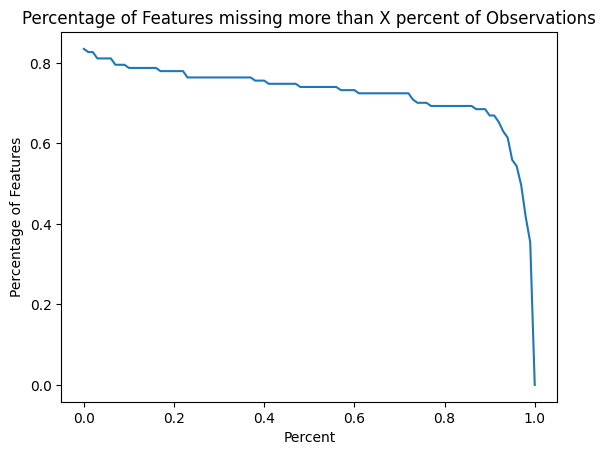

In [16]:
plt.figure()
plt.plot(percents,missing,linestyle="-")
plt.title("Percentage of Features missing more than X percent of Observations")
plt.ylabel("Percentage of Features")
plt.xlabel("Percent")
plt.show()

The general relative flatness of the missingness curve suggests that it is probably a common set of features which are generally missing observations. As such, we can probably choose to omit the columns which are missing more than some arbitrary percentage between 10\% and  80\% of observations. We use the cutoff 0.2, based on the intuition that 30\% missingness is unlikely to be catastrophic for downstream analyses without being too strict to exclude important but occasionally missing features

In [17]:
reduced = missing_vals[missing_vals>int(0.4*len(big))]
cols_to_drop = list(reduced.index)
cols_to_drop
print(cols_to_drop)
print(len(cols_to_drop)/len(big.columns))

['i/o_process_size', 'i/o_transistors', 'i/o_die_size', 'tjmax', 'launch_price', 'bundled_cooler', 'ppt', 'chipsets', 'integrated_graphics', 'npu', 'configurable_tdp', 'memory_capacity', 'tcasemax', 'retail_launch', 'p-core_turbo', 'p-core_boost_3.0', 'e-core_frequency', 'pl1', 'pl2', 'pl2_tau_limit', 'ddr4_speed', 'ddr5_speed', 'secondary_pcie', 'hybrid_cores', 'e-core_l1', 'e-core_l2', 'xfr', '3d_v-cache', 'tdp-down_frequency', 'boost_3.0', 'boost_2.0', 'configurable_tdp-down', 'boost_3.0_frequency', 'fp32', 'chipset', 'lpddr4x_speed', 'lpddr5_speed', '#_of_ccds', 'cores_per_ccd', 'all-core_turbo', 'lpddr4_speed', 'all_core_turbo', 'per-socket_pci-express', 'total_l3', 'adjustable_multiplier', 'qpi_links', 'tdp-down_freq.', 'tdp-up_freq.', 'lpddr3_speed', 'msrp', 'tdp_range', 'voltage', 'max._memory', 'mcr_dimm_speed', 'cxl', 'upi_links', 'avx-512_fma_ports', '2dpc_rated_speed', 'high_priority_core_freq.', 'low_priority_core_freq.', 'high_priority_cores', 'low_priority_cores', 'chips

So, now we plan on dropping about 75\% of the features.

In [18]:
model_specification_table = big.drop(columns=cols_to_drop)
model_specification_table

,Model,socket,foundry,process_size,transistors,die_size,package,market,production_status,release_date,...,memory_bus,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,cache_l1,cache_l2,cache_l3
0,AMD Ryzen 9 9950X,AMD Socket AM5,TSMC,4 nm,"16,630 million",2x 70.6 mm²,FC-LGA1718,Desktop,Active,"Aug 15th, 2024",...,Dual-channel,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,80 KB (per core),1 MB (per core),64 MB (shared)
1,AMD RYZEN AI MAX+ 395,AMD Socket FP11,TSMC,4 nm,NaN,2x 70.6 mm²,FC-BGA,Mobile,Active,"Jan 6th, 2025",...,Quad-channel,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,80 KB (per core),1 MB (per core),64 MB (shared)
2,Intel Core i9-13900K,Intel Socket 1700,Intel,10 nm,NaN,257 mm²,FC-LGA16A,Desktop,Active,"Sep 27th, 2022",...,Dual-channel,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,80 KB (per core),2 MB (per core),36 MB (shared)
3,AMD Ryzen 7 7700X,AMD Socket AM5,TSMC,5 nm,"6,570 million",71 mm²,FC-LGA1718,Desktop,Active,"Sep 27th, 2022",...,Dual-channel,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,64 KB (per core),1 MB (per core),32 MB (shared)
4,AMD Ryzen 9 7950X,AMD Socket AM5,TSMC,5 nm,"13,140 million",2x 71 mm²,FC-LGA1718,Desktop,Active,"Sep 27th, 2022",...,Dual-channel,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,Intel Xeon E5-2687W 0,Intel Socket 2011,Intel,32 nm,"2,270 million",435 mm²,FC-LGA10,Server/Workstation,unknown,"Mar 6th, 2012",...,Quad-channel,NaN,Yes,Gen 3,8.0,16.0,2.0,64 KB (per core),256 KB (per core),20 MB (shared)
425,Intel Core i7-12700KF,Intel Socket 1700,Intel,10 nm,NaN,215 mm²,FC-LGA16A,Desktop,Active,"Nov 4th, 2021",...,Dual-channel,NaN,No,"Gen 4, 20 Lanes (CPU only)",12,20,1,80 KB (per core),1.25 MB (per core),25 MB (shared)
426,Intel Xeon Gold 6144,Intel Socket 3647,Intel,14 nm,"8,000 million",NaN,FC-LGA3647,Server/Workstation,unknown,"Jul 11th, 2017",...,NaN,NaN,Yes,NaN,18.0,36.0,4.0,64 KB (per core),1 MB (per core),24.75 MB (shared)
427,Intel Core i7-1185G7E,Intel BGA 1449,Intel,10 nm,NaN,144 mm²,FC-BGA1449,Mobile,Active,"Sep 2nd, 2020",...,Dual-channel,NaN,No,"Gen 4, 4 Lanes (CPU only)",4,8,1,80 KB (per core),1.25 MB (per core),12 MB (shared)


Now, I should join the data.

In [19]:
long_data = pd.read_csv("../data/long_data.csv")

In [20]:
long_data

,Unnamed: 0,index,Component,Samples,Test,Units,Score,SD
0,0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40
1,1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181
2,2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242
3,3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53
4,4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608
...,...,...,...,...,...,...,...,...
1959,1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7
1960,1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535
1961,1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608
1962,1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55


In [21]:
print(len(long_data["Component"].unique()))

489


Need to merge across components. 

Probably, by merge if the Component column contains (as a substring) the Model column. 

Alternatively, I can process the Component column in the same manner as I did the Model column.

In [22]:
import re

# Matches: "2 x", "2x", "2 ×" (case-insensitive), with optional spaces
_MULTIPLIER_RE = re.compile(r'^\s*(?P<multi>\d+)\s*(?:x|×)\s*', re.IGNORECASE)

# Matches a *trailing* core/thread suffix like:
#  "32-Core", "32 Core", "32C", optionally plus "/ 64-Thread", ", 64 Threads", "and 64T"
#  optionally wrapped in parentheses, e.g. "(32-Core / 64-Thread)"
_TRAILING_CORES_THREADS_RE = re.compile(
    r"""
    \s*                              
    (?:\(\s*)?                       
    (?:[/,]|and)?\s*                 
    \d+\s*-?\s*(?:core|cores|c)\b    
    (?:                              
        \s*(?:[/,]|and)\s*
        \d+\s*-?\s*(?:thread|threads|t)\b
    )?
    \s*(?:\)\s*)?                    
    \s*$                             
    """,
    re.IGNORECASE | re.VERBOSE,
)

def normalize_model_and_multiplier(raw: str) -> tuple[str, int]:
    """
    Returns (base_model, multiplier).
      - base_model has any leading "<n> x" stripped
        and any trailing "<n>-Core[/<m>-Thread]" stripped.
      - multiplier is the leading <n> (default 1).
    """
    s = raw.strip()

    # 1) Extract leading multiplier (default 1)
    multiplier = 1
    m = _MULTIPLIER_RE.match(s)
    if m:
        multiplier = int(m.group("multi"))
        s = s[m.end():]  # chop it off

    # 2) Remove trailing core/thread decorations (only at end)
    s = _TRAILING_CORES_THREADS_RE.sub("", s)

    # 3) Collapse internal whitespace
    s = " ".join(s.split())
    return s, multiplier



In [23]:
models = long_data["Component"]

In [24]:
clean_models = []
multipliers = []
for model in models:
    #print(model)
    clean, mult = normalize_model_and_multiplier(model)
    clean_models.append(clean)
    multipliers.append(mult)

model_comparisons = pd.DataFrame({"Model":models,"Cleaned":clean_models, "Multipliers":multipliers})
print(model_comparisons)

                           Model                Cleaned  Multipliers
0      AMD Ryzen 9 9950X 16-Core      AMD Ryzen 9 9950X            1
1          AMD RYZEN AI MAX+ 395  AMD RYZEN AI MAX+ 395            1
2           Intel Core i9-13900K   Intel Core i9-13900K            1
3       AMD Ryzen 7 7700X 8-Core      AMD Ryzen 7 7700X            1
4      AMD Ryzen 9 7950X 16-Core      AMD Ryzen 9 7950X            1
...                          ...                    ...          ...
1959        Intel Core i3-1005G1   Intel Core i3-1005G1            1
1960  2 x AMD EPYC 7773X 64-Core         AMD EPYC 7773X            2
1961           AMD Ryzen 3 3200U      AMD Ryzen 3 3200U            1
1962         Intel Core i3-3110M    Intel Core i3-3110M            1
1963          Intel Core i7-7700     Intel Core i7-7700            1

[1964 rows x 3 columns]


I guess we should look at what models are contained in long_data but not in our specifications database.

In [25]:
benchmarked = model_comparisons["Cleaned"].unique()
scraped = big["Model"].unique()

diff = [i for i in benchmarked if i not in scraped]
diff

['AMD Custom APU 0405',
 'AMD A12-9720P RADEON R7 12 COMPUTE CORES 4C+8G',
 'Intel Pentium N4200',
 'Intel Atom x5-Z8350']

So, relatively few models are actually excluded.

In [26]:
long_data["Model"]=model_comparisons["Cleaned"]
long_data["Multiplier"]=model_comparisons["Multipliers"]
long_data

,Unnamed: 0,index,Component,Samples,Test,Units,Score,SD,Model,Multiplier
0,0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1
1,1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1
2,2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1
3,3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1
4,4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1
...,...,...,...,...,...,...,...,...,...,...
1959,1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1
1960,1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2
1961,1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1
1962,1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1


In [27]:
full_df = pd.merge(
    long_data,
    model_specification_table,
    left_on="Model",
    right_on="Model",
    how="inner"
)

In [28]:
full_df

,Unnamed: 0,index,Component,Samples,Test,Units,Score,SD,Model,Multiplier,...,memory_bus,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,cache_l1,cache_l2,cache_l3
0,0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,...,Dual-channel,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,80 KB (per core),1 MB (per core),64 MB (shared)
1,1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,...,Quad-channel,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,80 KB (per core),1 MB (per core),64 MB (shared)
2,2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,...,Dual-channel,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,80 KB (per core),2 MB (per core),36 MB (shared)
3,3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,...,Dual-channel,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,64 KB (per core),1 MB (per core),32 MB (shared)
4,4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,...,Dual-channel,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,...,Dual-channel,51.2 GB/s,No,Gen 3,2,4,1,64 KB (per core),256 KB (per core),4 MB (shared)
1954,1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,...,Eight-channel,204.8 GB/s,Yes,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,64 KB (per core),512 KB (per core),768 MB (shared)
1955,1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,...,Dual-channel,38.4 GB/s,No,Gen 3,2,4,1,96 KB (per core),512 KB (per core),4 MB (shared)
1956,1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,...,Dual-channel,NaN,No,NaN,2,4,1,64 KB (per core),256 KB (per core),3 MB (shared)


In [29]:
full_df.drop(columns=["Component","Unnamed: 0", "index"],inplace=True)

In [30]:
full_df

,Samples,Test,Units,Score,SD,Model,Multiplier,socket,foundry,process_size,...,memory_bus,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,cache_l1,cache_l2,cache_l3
0,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,AMD Socket AM5,TSMC,4 nm,...,Dual-channel,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,80 KB (per core),1 MB (per core),64 MB (shared)
1,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,AMD Socket FP11,TSMC,4 nm,...,Quad-channel,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,80 KB (per core),1 MB (per core),64 MB (shared)
2,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,Intel Socket 1700,Intel,10 nm,...,Dual-channel,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,80 KB (per core),2 MB (per core),36 MB (shared)
3,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,AMD Socket AM5,TSMC,5 nm,...,Dual-channel,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,64 KB (per core),1 MB (per core),32 MB (shared)
4,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,AMD Socket AM5,TSMC,5 nm,...,Dual-channel,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,Intel BGA 1526,Intel,10 nm,...,Dual-channel,51.2 GB/s,No,Gen 3,2,4,1,64 KB (per core),256 KB (per core),4 MB (shared)
1954,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,AMD Socket SP3,TSMC,7 nm,...,Eight-channel,204.8 GB/s,Yes,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,64 KB (per core),512 KB (per core),768 MB (shared)
1955,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,AMD Socket FP5,GlobalFoundries,14 nm,...,Dual-channel,38.4 GB/s,No,Gen 3,2,4,1,96 KB (per core),512 KB (per core),4 MB (shared)
1956,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,Intel Socket G2 (988B),Intel,22 nm,...,Dual-channel,NaN,No,NaN,2,4,1,64 KB (per core),256 KB (per core),3 MB (shared)


In [31]:
full_df.columns

Index(['Samples', 'Test', 'Units', 'Score', 'SD', 'Model', 'Multiplier',
       'socket', 'foundry', 'process_size', 'transistors', 'die_size',
       'package', 'market', 'production_status', 'release_date', 'part#',
       'frequency', 'turbo_clock', 'base_clock', 'multiplier',
       'multiplier_unlocked', 'tdp', 'codename', 'generation',
       'memory_support', 'rated_speed', 'memory_bus', 'memory_bandwidth',
       'ecc_memory', 'pci-express', '#_of_cores', '#_of_threads', 'smp_#_cpus',
       'cache_l1', 'cache_l2', 'cache_l3'],
      dtype='object')

In [32]:
full_df.to_csv("full_data.csv",index=False)